# Computer Vision Masterclass: GANs

- Adapted from: https://www.tensorflow.org/beta/tutorials/generative/dcgan

## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.10.0'

## Loading and pre-processing the dataset

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
28 * 28

784

In [5]:
y_train.shape

(60000,)

In [6]:
np.random.randint(0, 60000)

39741

2


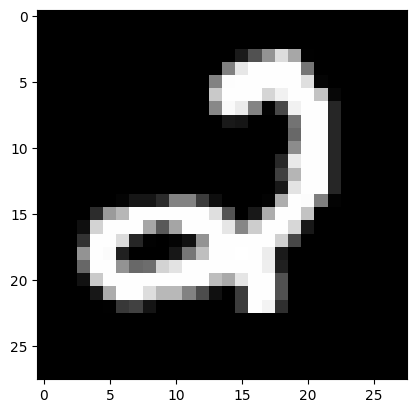

In [7]:
i = np.random.randint(0, 60000)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray');

In [8]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [9]:
X_train.shape

(60000, 28, 28, 1)

In [10]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [11]:
# X_train = X_train / 255
X_train = (X_train - 127.5) / 127.5

In [12]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [13]:
buffer_size = 60000
batch_size = 256

In [14]:
buffer_size / batch_size

234.375

In [15]:
type(X_train)

numpy.ndarray

In [16]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [17]:
type(X_train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [18]:
X_train

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Building the generator

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [19]:
7*7*256

12544

In [20]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7, 7, 256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding='same', use_bias=False, activation='tanh'))

  network.summary()

  return network

In [21]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [22]:
noise = tf.random.normal([1, 100])

In [23]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.0575219 , -0.74945295,  1.6108822 ,  2.0302143 ,  1.1846578 ,
         0.59178716,  0.70689857,  1.0452844 ,  0.8824369 ,  1.9230484 ,
        -0.00391873, -2.214131  ,  2.133005  ,  0.56621075, -0.98041   ,
         1.9991397 ,  1.9387174 ,  0.5512679 ,  0.2085967 , -0.20429254,
         0.50141305, -0.26372376,  0.2876961 ,  1.9106884 , -1.0485052 ,
        -0.00461021,  1.1952845 ,  1.5041304 , -0.7069897 ,  1.1645913 ,
         0.6510581 ,  0.6470686 ,  0.21089804, -0.84377027,  0.08932124,
         0.54796827,  0.633832  , -1.0707551 , -0.81329817, -0.27736595,
        -1.3465238 ,  0.86224204, -0.15472156,  1.8165157 ,  0.31358793,
         0.11541229,  1.079825  , -1.0358489 ,  1.1797528 , -1.0196947 ,
         0.72202307, -0.12810199,  0.19086002,  0.8031947 ,  0.6072611 ,
        -0.4472781 , -0.79014444,  0.26108903, -0.86217624,  1.448855  ,
        -0.0025184 ,  0.9465582 ,  0.12199308,  0.01584928, -0.48823774,
 

In [24]:
generated_image = generator(noise, training = False)

In [25]:
generated_image.shape

TensorShape([1, 28, 28, 1])

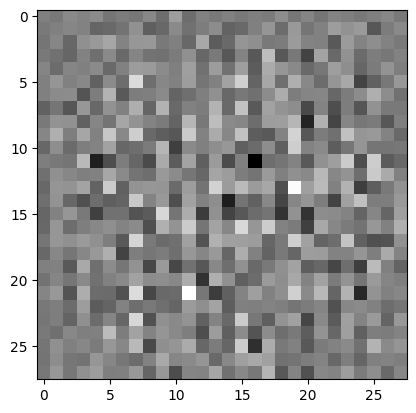

In [26]:
plt.imshow(generated_image[0,:,:,0], cmap='gray');

## Building the discriminator

- Dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [27]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [28]:
7 * 7 * 128

6272

In [29]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [30]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00231292]], dtype=float32)>

## Calculating the loss

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [31]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [33]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

## Training the model

In [35]:
X_train

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [36]:
epochs = 100
noise_dim = 100
num_images_to_generate = 16

In [37]:
batch_size, noise_dim

(256, 100)

In [38]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [39]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])

In [40]:
test_images.shape

TensorShape([16, 100])

In [41]:
60000 / 256

234.375

In [42]:
def train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      #print(image_batch.shape)
      train_steps(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Epoch:  1


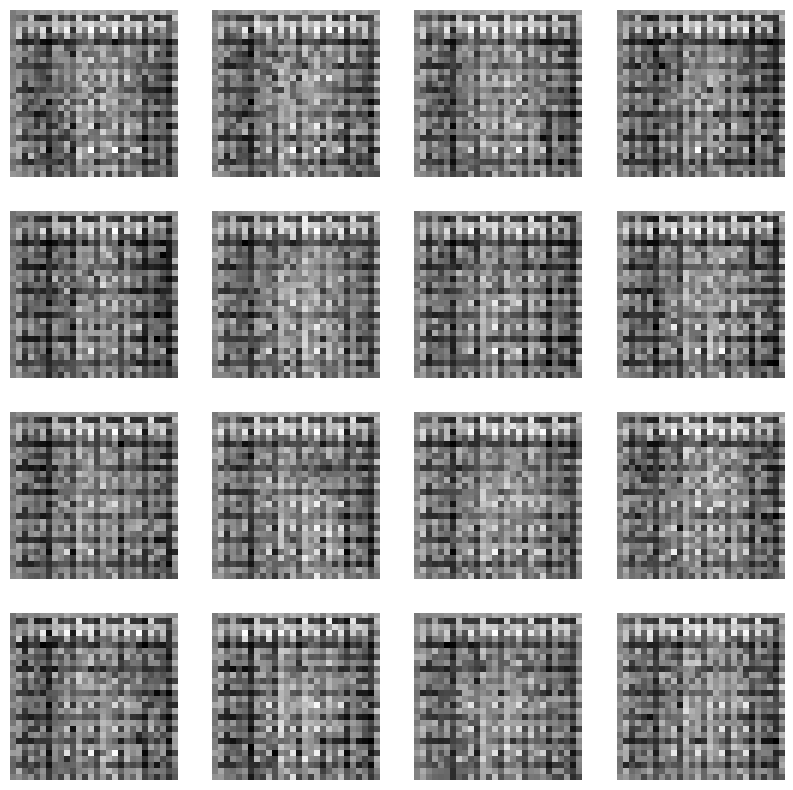

Epoch:  2


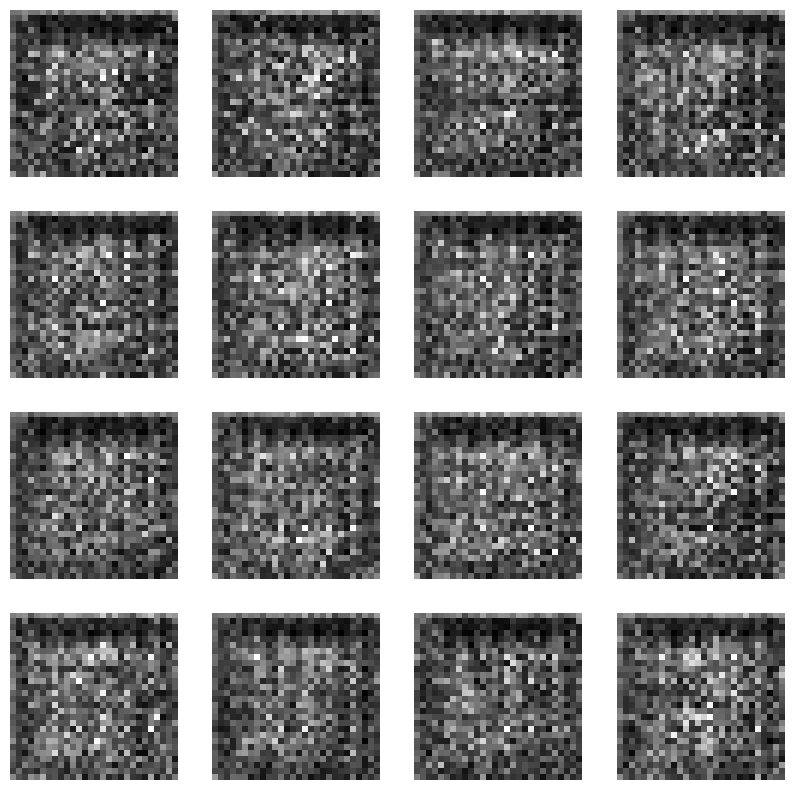

Epoch:  3


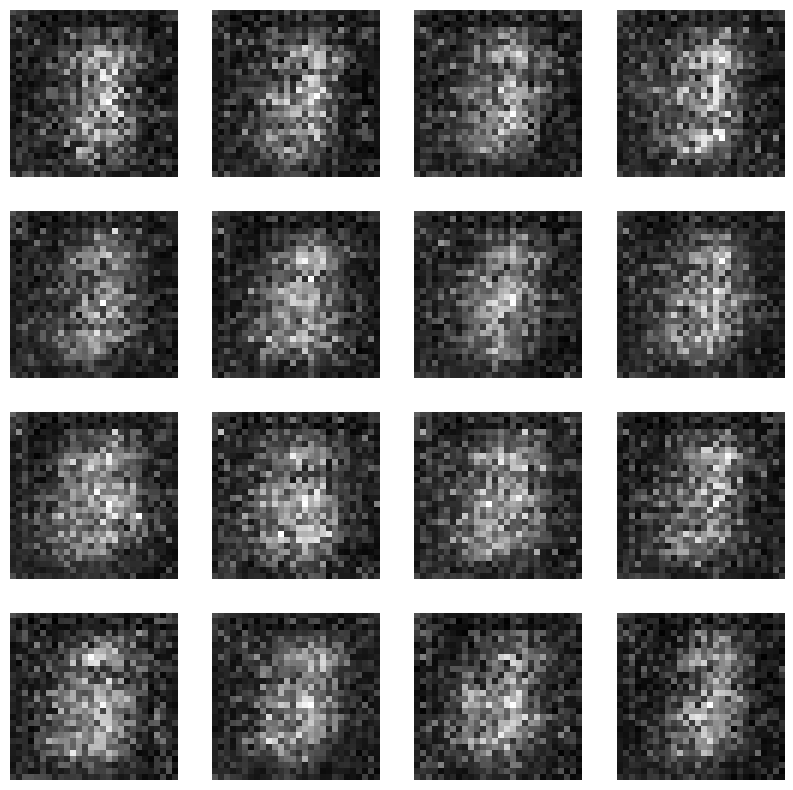

Epoch:  4


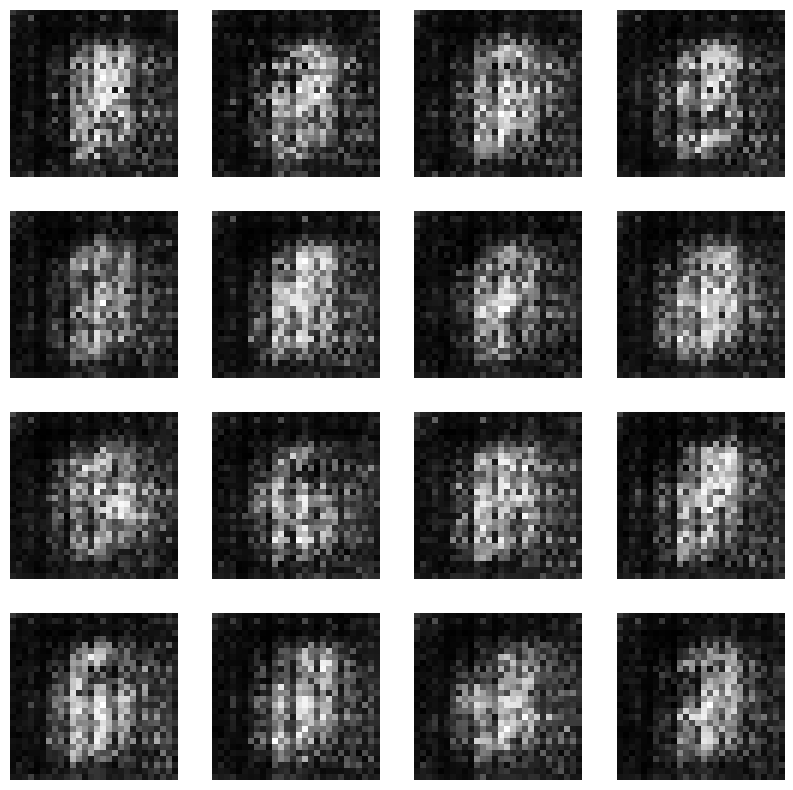

Epoch:  5


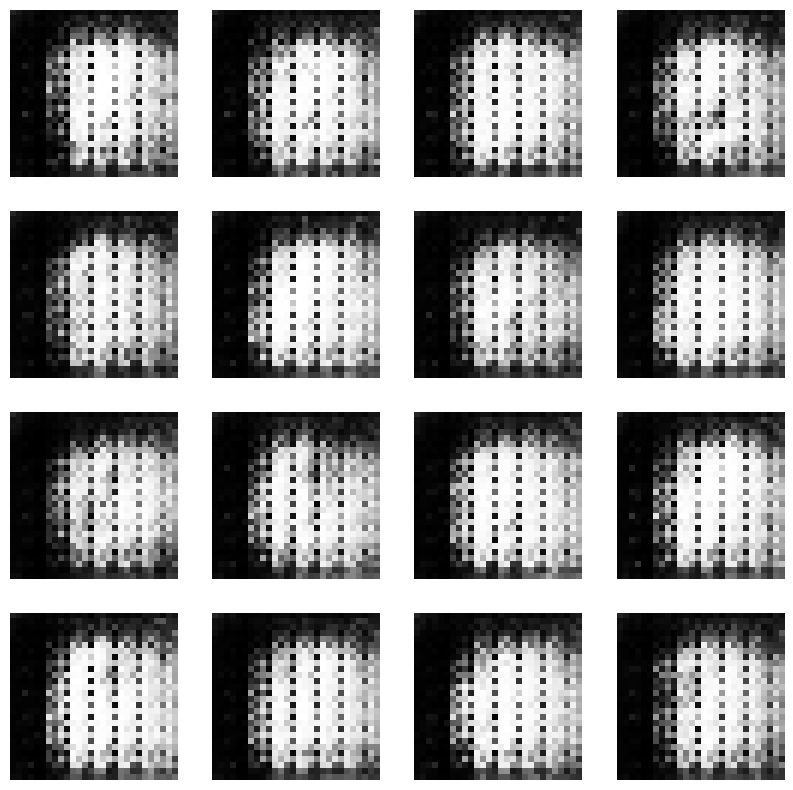

Epoch:  6


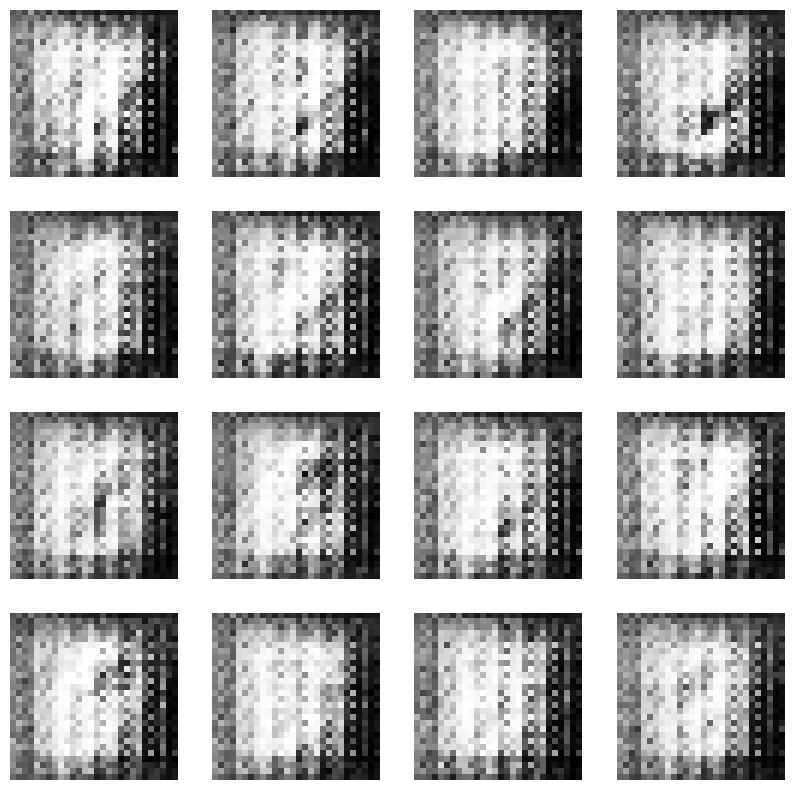

Epoch:  7


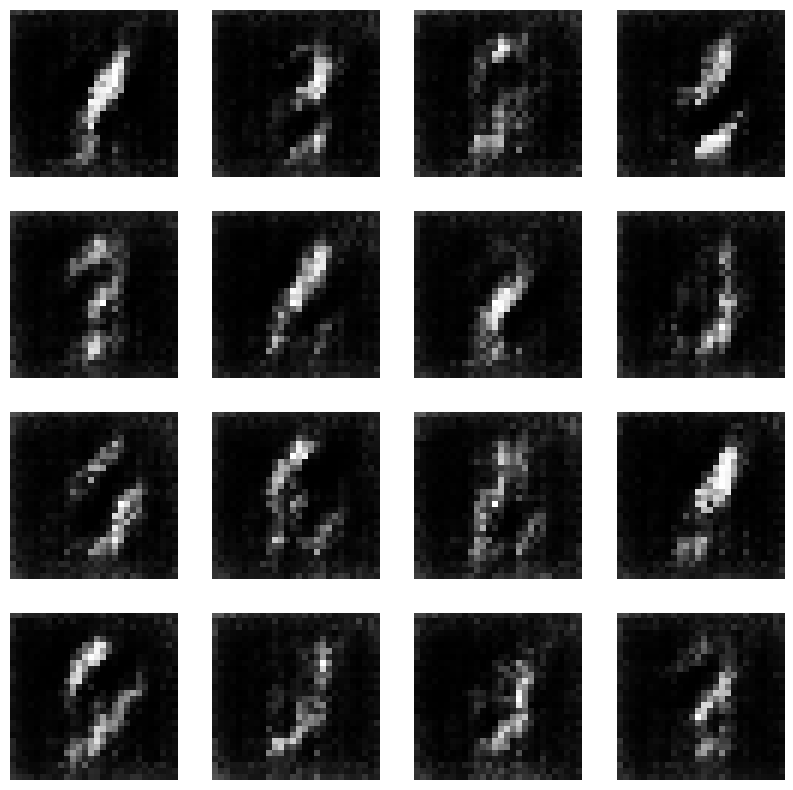

Epoch:  8


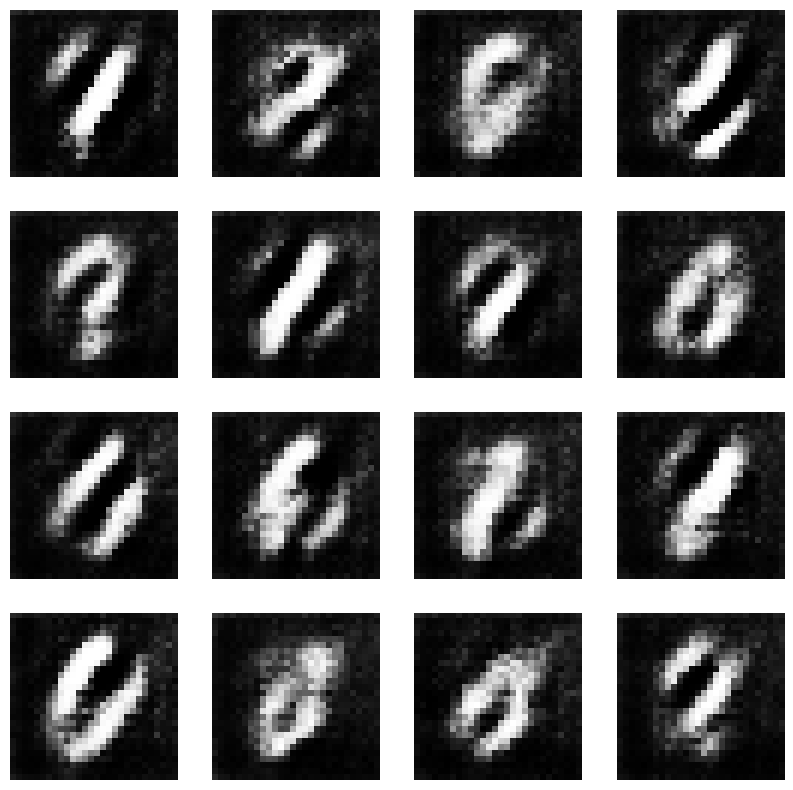

Epoch:  9


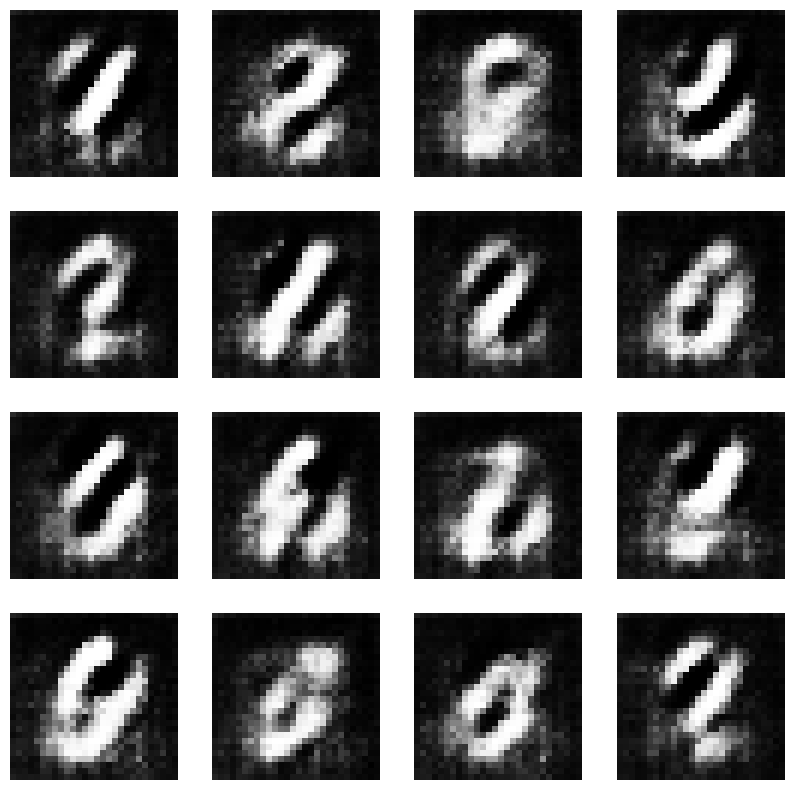

Epoch:  10


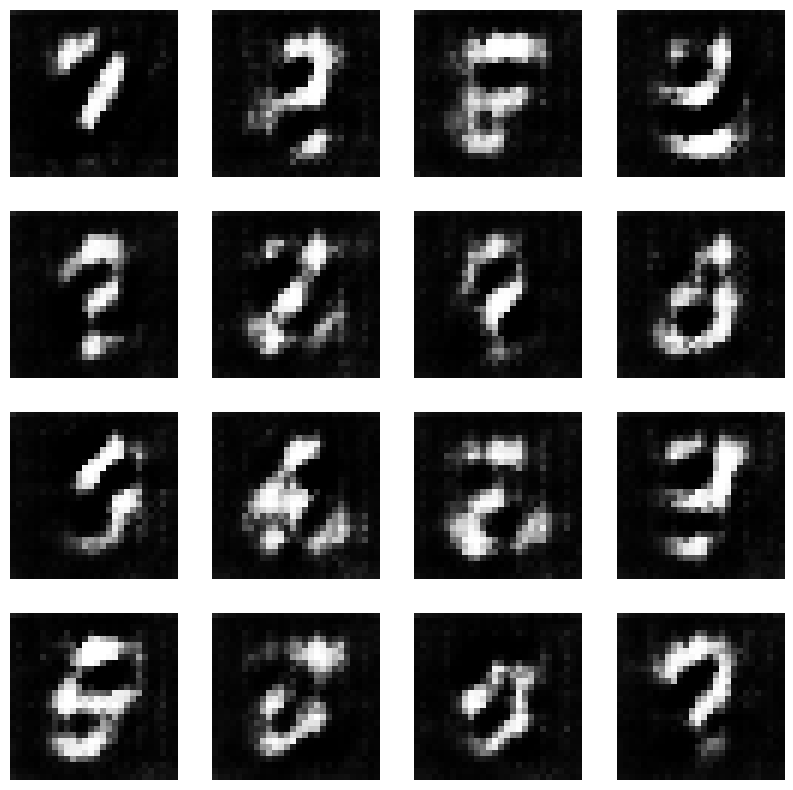

Epoch:  11


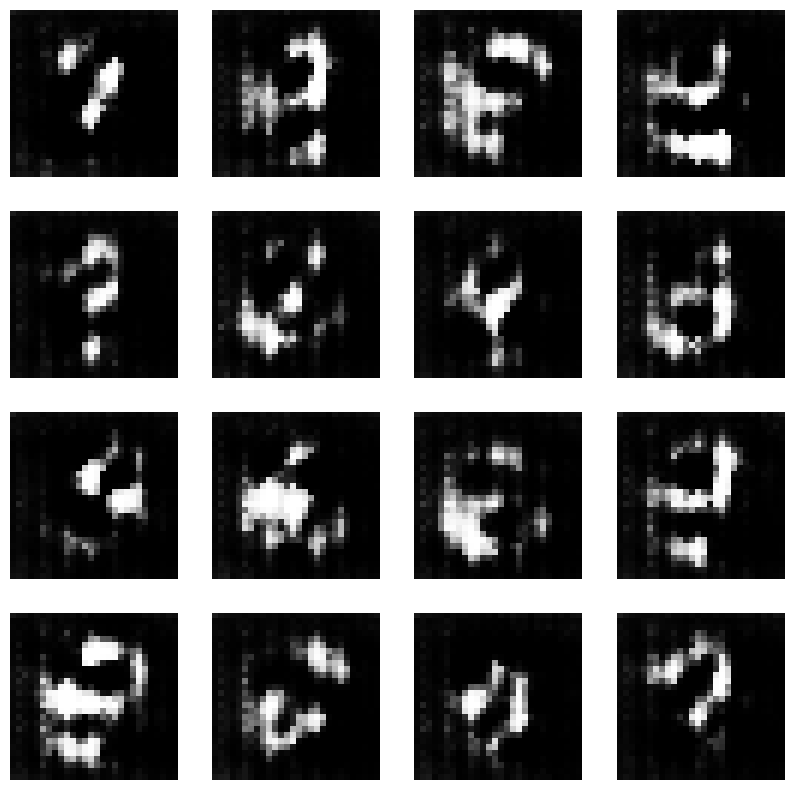

Epoch:  12


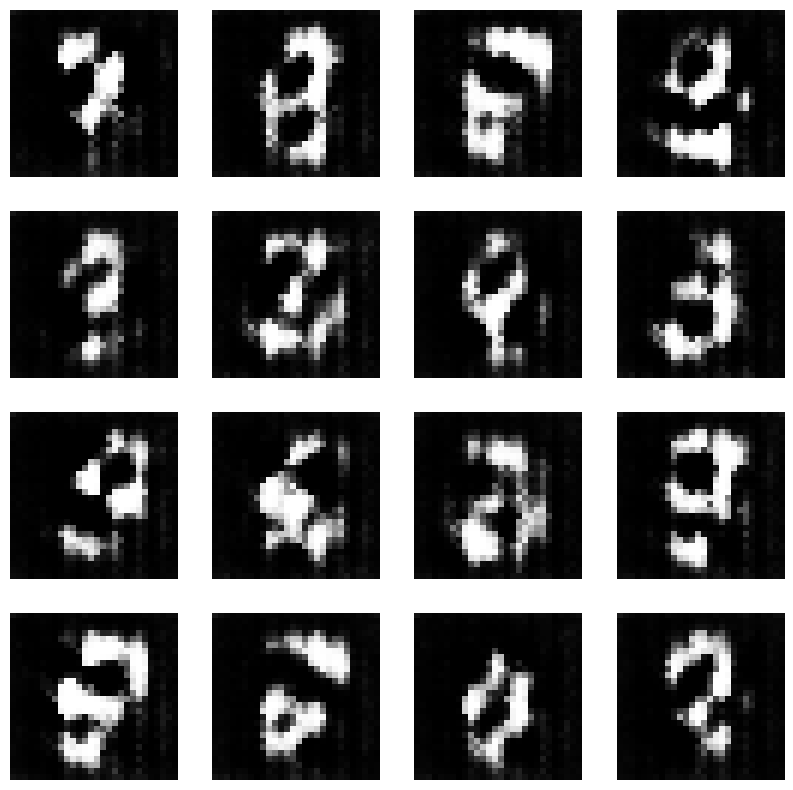

Epoch:  13


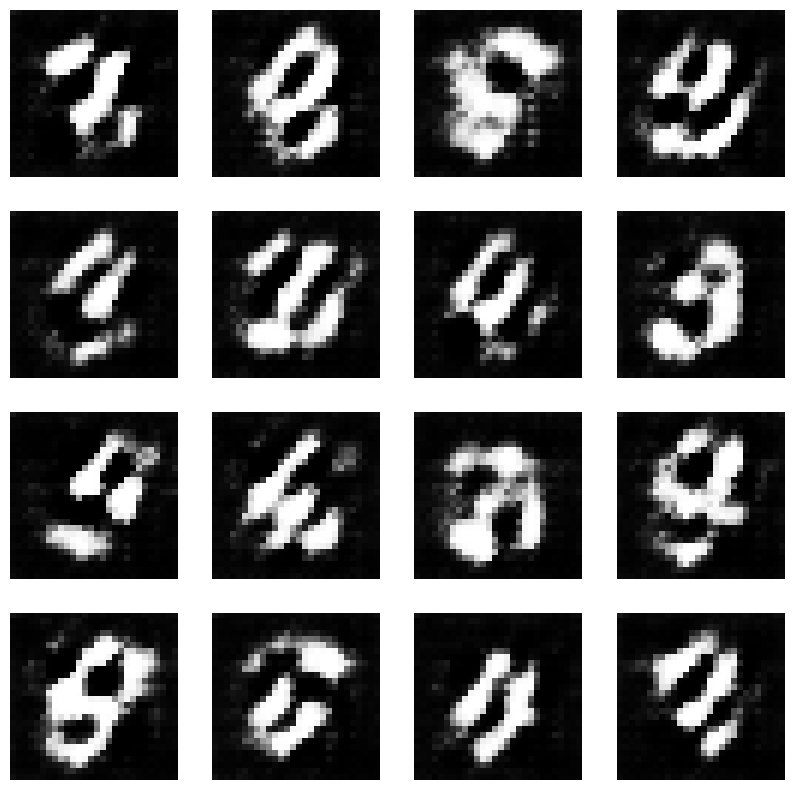

Epoch:  14


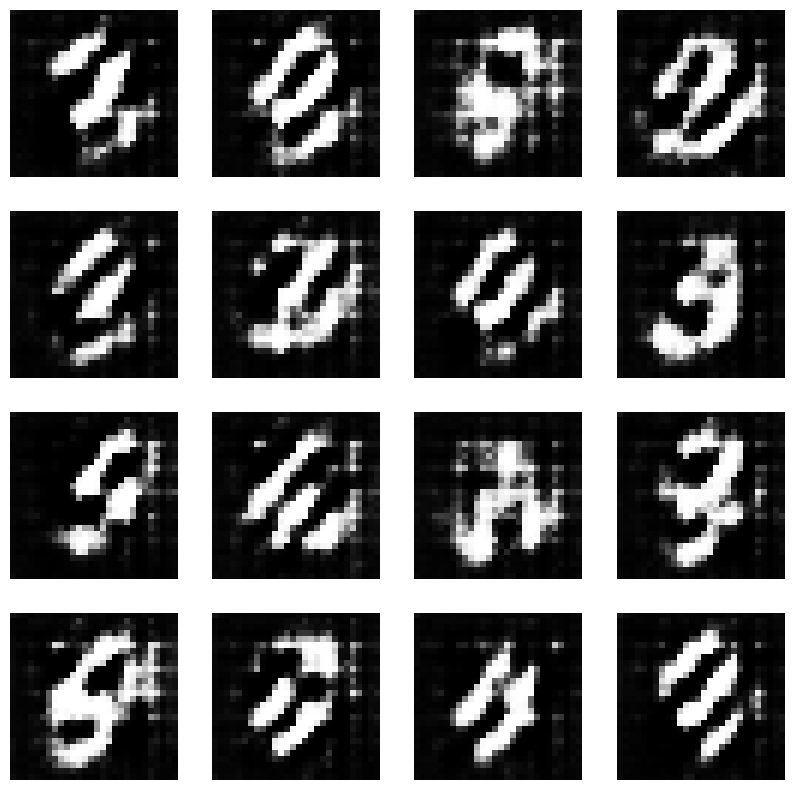

In [43]:
train(X_train, epochs, test_images)